# 🦻 Teaching Machines to Understand Sign Language  
**Local version** – no Google Drive, no Colab, no secrets.  
Each code block is **heavily instrumented** so you can *see* every stage instead of guessing.

## 0. One-time environment check

In [1]:
# Built-in sanity checks – run once, ignore if everything is green
import sys, subprocess, pathlib, os

def run(cmd): return subprocess.check_output(cmd, shell=True).decode().strip()

print("Python:", sys.version)
print("Working dir:", pathlib.Path.cwd())

pkgs = "tensorflow opencv-python mediapipe numpy pandas scikit-learn matplotlib".split()
missing = [p for p in pkgs if run(f"{sys.executable} -m pip show {p}") == ""]
if missing:
    print("❗ Missing packages:", missing)
    print("👉 Install with: pip install", " ".join(missing))
else:
    print("✅ All required packages found")

Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
Working dir: d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM
✅ All required packages found


## 1. Imports & reproducibility

In [2]:
# General utilities
import os, time, random, json, math, itertools
from pathlib import Path

# Scientific
import numpy as np
import pandas as pd
import scipy.stats


# Vision
import cv2
import mediapipe as mp
import seaborn as sns

# ML / DL
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, SpatialDropout1D, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Visualization
import matplotlib.pyplot as plt
from IPython.display import Image, Video, clear_output

# Reproducible results
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("✅ All libraries imported – TensorFlow version:", tf.__version__)


✅ All libraries imported – TensorFlow version: 2.15.0


## 2. Project folder tree (local)

In [3]:
PROJECT_ROOT = Path.cwd() / "sign_language_V5_12kata"
DATA_PATH    = PROJECT_ROOT / "MP_Data"
VIDEO_PATH   = PROJECT_ROOT / "videos"
TEST_PATH    = PROJECT_ROOT / "test_videos"
LOG_PATH     = PROJECT_ROOT / "Logs"
MODEL_PATH   = PROJECT_ROOT / "my_model.keras"

for p in (PROJECT_ROOT, DATA_PATH, VIDEO_PATH, TEST_PATH, LOG_PATH):
    p.mkdir(parents=True, exist_ok=True)

print("📁 Project tree created at:", PROJECT_ROOT)
!tree -L 2 {PROJECT_ROOT} 2>/dev/null || find {PROJECT_ROOT} -type d | head -10

📁 Project tree created at: d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata


The system cannot find the path specified.
'head' is not recognized as an internal or external command,
operable program or batch file.


## 3. Action vocabulary

In [4]:
# ACTIONS           = np.array(["saya", "mau", "makan", "diam"])
ACTIONS           = np.array(["saya", "mau", "makan", "diam","kamu", "siapa", "tolong", "apa", "kenalkan","nama"])
NO_SEQUENCES      = 100          
SEQUENCE_LENGTH   = 30          
START_FOLDER      = 0
stride            = 15          

label_map = {label: idx for idx, label in enumerate(ACTIONS)}

## 4. MediaPipe helpers (unchanged logic)

In [5]:
mp_holistic = mp.solutions.holistic
mp_drawing  = mp.solutions.drawing_utils


def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    # Pose
    mp_drawing.draw_landmarks(
        image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(80,22,10),  thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    # Left hand
    mp_drawing.draw_landmarks(
        image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121,22,76),  thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    # Right hand
    mp_drawing.draw_landmarks(
        image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh   = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh   = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

print("✅ MediaPipe helpers defined – feature vector length =", len(extract_keypoints(mp_holistic.Holistic().process(np.zeros((480,640,3), dtype=np.uint8)))))

✅ MediaPipe helpers defined – feature vector length = 1662


## 5. Create folder structure for data collection

In [6]:
for action in ACTIONS:
    action_dir = DATA_PATH / action
    action_dir.mkdir(exist_ok=True)
    for seq in range(NO_SEQUENCES):
        (action_dir / str(seq)).mkdir(exist_ok=True)

print("✅ Folder structure created – example:")
!tree -L 3 {DATA_PATH} | head -15

✅ Folder structure created – example:


'head' is not recognized as an internal or external command,
operable program or batch file.


## 6. Collect key-points from local videos

In [7]:
def augment_keypoints_improved(kp):

    kp = kp.copy()
    
    # 1. Gaussian noise (sangat kecil)
    noise = np.random.normal(0, 0.003, kp.shape)
    kp = kp + noise
    
    # 2. Random scaling (95%-105%)
    scale = np.random.uniform(0.95, 1.05)
    kp = kp * scale
    
    # 3. Small temporal shift (simulasi delay)
    if np.random.rand() > 0.5:
        shift_amount = np.random.uniform(-0.002, 0.002)
        kp = kp + shift_amount
    
    return np.clip(kp, 0, 1)  # Pastikan dalam range [0,1]

def visualize_keypoints_on_frame(frame, keypoints, title="Keypoints Visualization"):
    """
    Visualisasi keypoints yang sudah diekstrak kembali ke frame
    """
    vis_frame = frame.copy()
    h, w, _ = vis_frame.shape
    
    # Parse keypoints (sesuaikan dengan struktur extract_keypoints_with_motion)
    pose_end = 33 * 4
    face_end = pose_end + 468 * 3
    lh_end = face_end + 21 * 3
    rh_end = lh_end + 21 * 3
    
    pose_kp = keypoints[:pose_end].reshape(-1, 4)
    lh_kp = keypoints[face_end:lh_end].reshape(-1, 3)
    rh_kp = keypoints[lh_end:rh_end].reshape(-1, 3)
    
    # Draw pose keypoints (hanya x, y)
    for i, (x, y, z, vis) in enumerate(pose_kp):
        if vis > 0.5:  # Hanya gambar jika visibility tinggi
            cv2.circle(vis_frame, (int(x * w), int(y * h)), 3, (80, 44, 121), -1)
    
    # Draw left hand (hijau)
    for i, (x, y, z) in enumerate(lh_kp):
        if not np.allclose([x, y, z], 0):  # Skip jika zero (tidak terdeteksi)
            cv2.circle(vis_frame, (int(x * w), int(y * h)), 4, (0, 255, 0), -1)
            cv2.putText(vis_frame, str(i), (int(x * w), int(y * h)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    
    # Draw right hand (merah)
    for i, (x, y, z) in enumerate(rh_kp):
        if not np.allclose([x, y, z], 0):
            cv2.circle(vis_frame, (int(x * w), int(y * h)), 4, (0, 0, 255), -1)
            cv2.putText(vis_frame, str(i), (int(x * w), int(y * h)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    
    # Add title
    cv2.putText(vis_frame, title, (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    
    return vis_frame
def visualize_augmentation_comparison(original_kp, augmented_kp, frame_shape=(480, 640, 3)):
    """
    Bandingkan keypoints original vs augmented side-by-side
    """
    h, w, _ = frame_shape
    
    # Buat canvas kosong
    original_canvas = np.zeros(frame_shape, dtype=np.uint8)
    augmented_canvas = np.zeros(frame_shape, dtype=np.uint8)
    
    # Parse keypoints
    face_end = 33 * 4 + 468 * 3
    lh_end = face_end + 21 * 3
    
    # Draw original
    lh_orig = original_kp[face_end:lh_end].reshape(-1, 3)
    rh_orig = original_kp[lh_end:lh_end + 21*3].reshape(-1, 3)
    
    for x, y, z in lh_orig:
        if not np.allclose([x, y, z], 0):
            cv2.circle(original_canvas, (int(x * w), int(y * h)), 5, (0, 255, 0), -1)
    
    for x, y, z in rh_orig:
        if not np.allclose([x, y, z], 0):
            cv2.circle(original_canvas, (int(x * w), int(y * h)), 5, (0, 0, 255), -1)
    
    # Draw augmented
    lh_aug = augmented_kp[face_end:lh_end].reshape(-1, 3)
    rh_aug = augmented_kp[lh_end:lh_end + 21*3].reshape(-1, 3)
    
    for x, y, z in lh_aug:
        if not np.allclose([x, y, z], 0):
            cv2.circle(augmented_canvas, (int(x * w), int(y * h)), 5, (0, 255, 0), -1)
    
    for x, y, z in rh_aug:
        if not np.allclose([x, y, z], 0):
            cv2.circle(augmented_canvas, (int(x * w), int(y * h)), 5, (0, 0, 255), -1)
    
    # Add labels
    cv2.putText(original_canvas, "ORIGINAL", (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(augmented_canvas, "AUGMENTED", (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    
    # Combine side by side
    combined = np.hstack([original_canvas, augmented_canvas])
    return combined


# ===== 3. FEATURE ENGINEERING: TAMBAHKAN VELOCITY & ACCELERATION =====
def extract_keypoints_with_motion(results):
    # Cek kualitas deteksi - skip jika tangan tidak terdeteksi sama sekali
    hands_detected = results.left_hand_landmarks or results.right_hand_landmarks
    
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    keypoints = np.concatenate([pose, face, lh, rh])
    
    # Return None jika deteksi terlalu buruk (untuk portrait yang terlalu crop)
    if not hands_detected and not results.pose_landmarks:
        return None
    
    return keypoints


def compute_motion_features(sequence):
    """
    Hitung velocity (frame[t] - frame[t-1]) dan acceleration
    Ini PENTING untuk bedakan gerakan statis vs dinamis
    """
    seq_array = np.array(sequence)
    
    # Velocity (first derivative)
    velocity = np.diff(seq_array, axis=0)
    velocity = np.vstack([np.zeros((1, velocity.shape[1])), velocity])
    
    # Acceleration (second derivative)
    acceleration = np.diff(velocity, axis=0)
    acceleration = np.vstack([np.zeros((1, acceleration.shape[1])), acceleration])
    
    # Gabungkan: [original, velocity, acceleration]
    return np.concatenate([seq_array, velocity, acceleration], axis=1)


# ===== 4. PROSES VIDEO DENGAN MOTION FEATURES =====
def process_videos_with_motion(visualize=True, save_visualization=False):
    """
    visualize: Tampilkan real-time visualization
    save_visualization: Simpan video hasil visualisasi
    """
    holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    
    for action in ACTIONS:
        video_dir = VIDEO_PATH / action
        videos = sorted(list(video_dir.glob("*.mp4")) + list(video_dir.glob("*.mov")))
        videos = videos[:NO_SEQUENCES]
        print(f"\n🎬 Processing {len(videos)} videos for '{action}'")
        seq_idx = 0
        
        for vfile in videos:
            cap = cv2.VideoCapture(str(vfile))
            fps = int(cap.get(cv2.CAP_PROP_FPS))
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            
            frames_kp = []
            frames_raw = []  # Simpan frame asli untuk visualisasi
            skipped_frames = 0
            
            # Setup video writer jika save_visualization=True
            if save_visualization:
                vis_output_path = PROJECT_ROOT / "visualizations" / f"{action}_{vfile.stem}_vis.mp4"
                vis_output_path.parent.mkdir(exist_ok=True)
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                out = cv2.VideoWriter(str(vis_output_path), fourcc, fps, (width, height))
            
            print(f"  📹 Processing {vfile.name} ({width}x{height})")
            
            frame_count = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                frame_count += 1
                image, results = mediapipe_detection(frame, holistic)
                
                # Visualisasi real-time
                if visualize:
                    draw_styled_landmarks(image, results)
                    
                    # Tampilkan info
                    info_text = f"Frame: {frame_count} | Action: {action}"
                    cv2.putText(image, info_text, (10, height - 20), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                    
                    # Deteksi status
                    hand_status = "✓ Hands Detected" if (results.left_hand_landmarks or results.right_hand_landmarks) else "✗ No Hands"
                    color = (0, 255, 0) if "✓" in hand_status else (0, 0, 255)
                    cv2.putText(image, hand_status, (10, 60), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                    
                    # Show frame
                    cv2.imshow(f'Processing: {action}', image)
                    
                    # Save visualization
                    if save_visualization:
                        out.write(image)
                    
                    # Press 'q' to skip video, 'ESC' to stop all
                    key = cv2.waitKey(1) & 0xFF
                    if key == ord('q'):
                        print(f"  ⏭️  Skipping video...")
                        break
                    elif key == 27:  # ESC
                        print(f"  🛑 Stopping all processing...")
                        cap.release()
                        if save_visualization:
                            out.release()
                        cv2.destroyAllWindows()
                        holistic.close()
                        return
                
                # Extract keypoints
                kp = extract_keypoints_with_motion(results)
                
                if kp is not None:
                    frames_kp.append(kp)
                    frames_raw.append(frame)
                else:
                    skipped_frames += 1
            
            cap.release()
            if save_visualization:
                out.release()
            
            if skipped_frames > 0:
                print(f"  ⚠️  {skipped_frames} frames skipped (poor detection)")
            
            if len(frames_kp) < SEQUENCE_LENGTH:
                print(f"  ❌ Only {len(frames_kp)} frames, need min {SEQUENCE_LENGTH}")
                continue
            
            # Extract sequences
            sequences_created = 0
            for start in range(0, len(frames_kp) - SEQUENCE_LENGTH + 1, stride):
                window = frames_kp[start:start + SEQUENCE_LENGTH]
                
                # Save original sequence
                save_dir = DATA_PATH / action / str(seq_idx)
                save_dir.mkdir(parents=True, exist_ok=True)
                for t, kp in enumerate(window):
                    np.save(save_dir / f"{t}.npy", kp)
                seq_idx += 1
                sequences_created += 1
                
                # Augmentasi dengan visualisasi
                if np.random.rand() > 0.5:
                    aug_window = [augment_keypoints_improved(kp) for kp in window]
                    
                    # Visualisasi augmentasi (hanya untuk sequence pertama)
                    if visualize and sequences_created == 1:
                        # Ambil frame tengah untuk perbandingan
                        mid_frame = frames_raw[start + SEQUENCE_LENGTH // 2]
                        comparison = visualize_augmentation_comparison(
                            window[SEQUENCE_LENGTH // 2], 
                            aug_window[SEQUENCE_LENGTH // 2],
                            mid_frame.shape
                        )
                        cv2.imshow('Augmentation Comparison', comparison)
                        cv2.waitKey(1000)  # Tampilkan 1 detik
                    
                    # Save augmented sequence
                    save_dir_aug = DATA_PATH / action / str(seq_idx)
                    save_dir_aug.mkdir(parents=True, exist_ok=True)
                    for t, kp in enumerate(aug_window):
                        np.save(save_dir_aug / f"{t}.npy", kp)
                    seq_idx += 1
                    sequences_created += 1
            
            print(f"  ✅ {sequences_created} sequences created from this video")
        
        print(f"  📦 Total {seq_idx} sequences saved for '{action}'")
    
    cv2.destroyAllWindows()
    holistic.close()


# Visualisasi tanpa save video
# process_videos_with_motion(visualize=True, save_visualization=False)

# Visualisasi DAN save hasil processing
# process_videos_with_motion(visualize=True, save_visualization=True)

# Untuk production, lebih cepat
process_videos_with_motion(visualize=False, save_visualization=False)


🎬 Processing 100 videos for 'saya'
  📹 Processing saya_01_edited.mp4 (640x480)
  ✅ 3 sequences created from this video
  📹 Processing saya_02_edited.mp4 (640x480)
  ✅ 2 sequences created from this video
  📹 Processing saya_03_edited.mp4 (640x480)
  ✅ 2 sequences created from this video
  📹 Processing saya_04_edited.mp4 (640x480)
  ✅ 2 sequences created from this video
  📹 Processing saya_05_edited.mp4 (640x480)
  ✅ 3 sequences created from this video
  📹 Processing saya_06_edited.mp4 (640x480)
  ✅ 4 sequences created from this video
  📹 Processing saya_07_edited.mp4 (640x480)
  ✅ 3 sequences created from this video
  📹 Processing saya_08_edited.mp4 (640x480)
  ✅ 4 sequences created from this video
  📹 Processing saya_09_edited.mp4 (640x480)
  ✅ 2 sequences created from this video
  📹 Processing saya_100_edited.mp4 (640x480)
  ✅ 3 sequences created from this video
  📹 Processing saya_10_edited.mp4 (640x480)
  ✅ 2 sequences created from this video
  📹 Processing saya_11_edited.mp4 (640x

✅ Loaded 4 actions × 4 augmentation variants


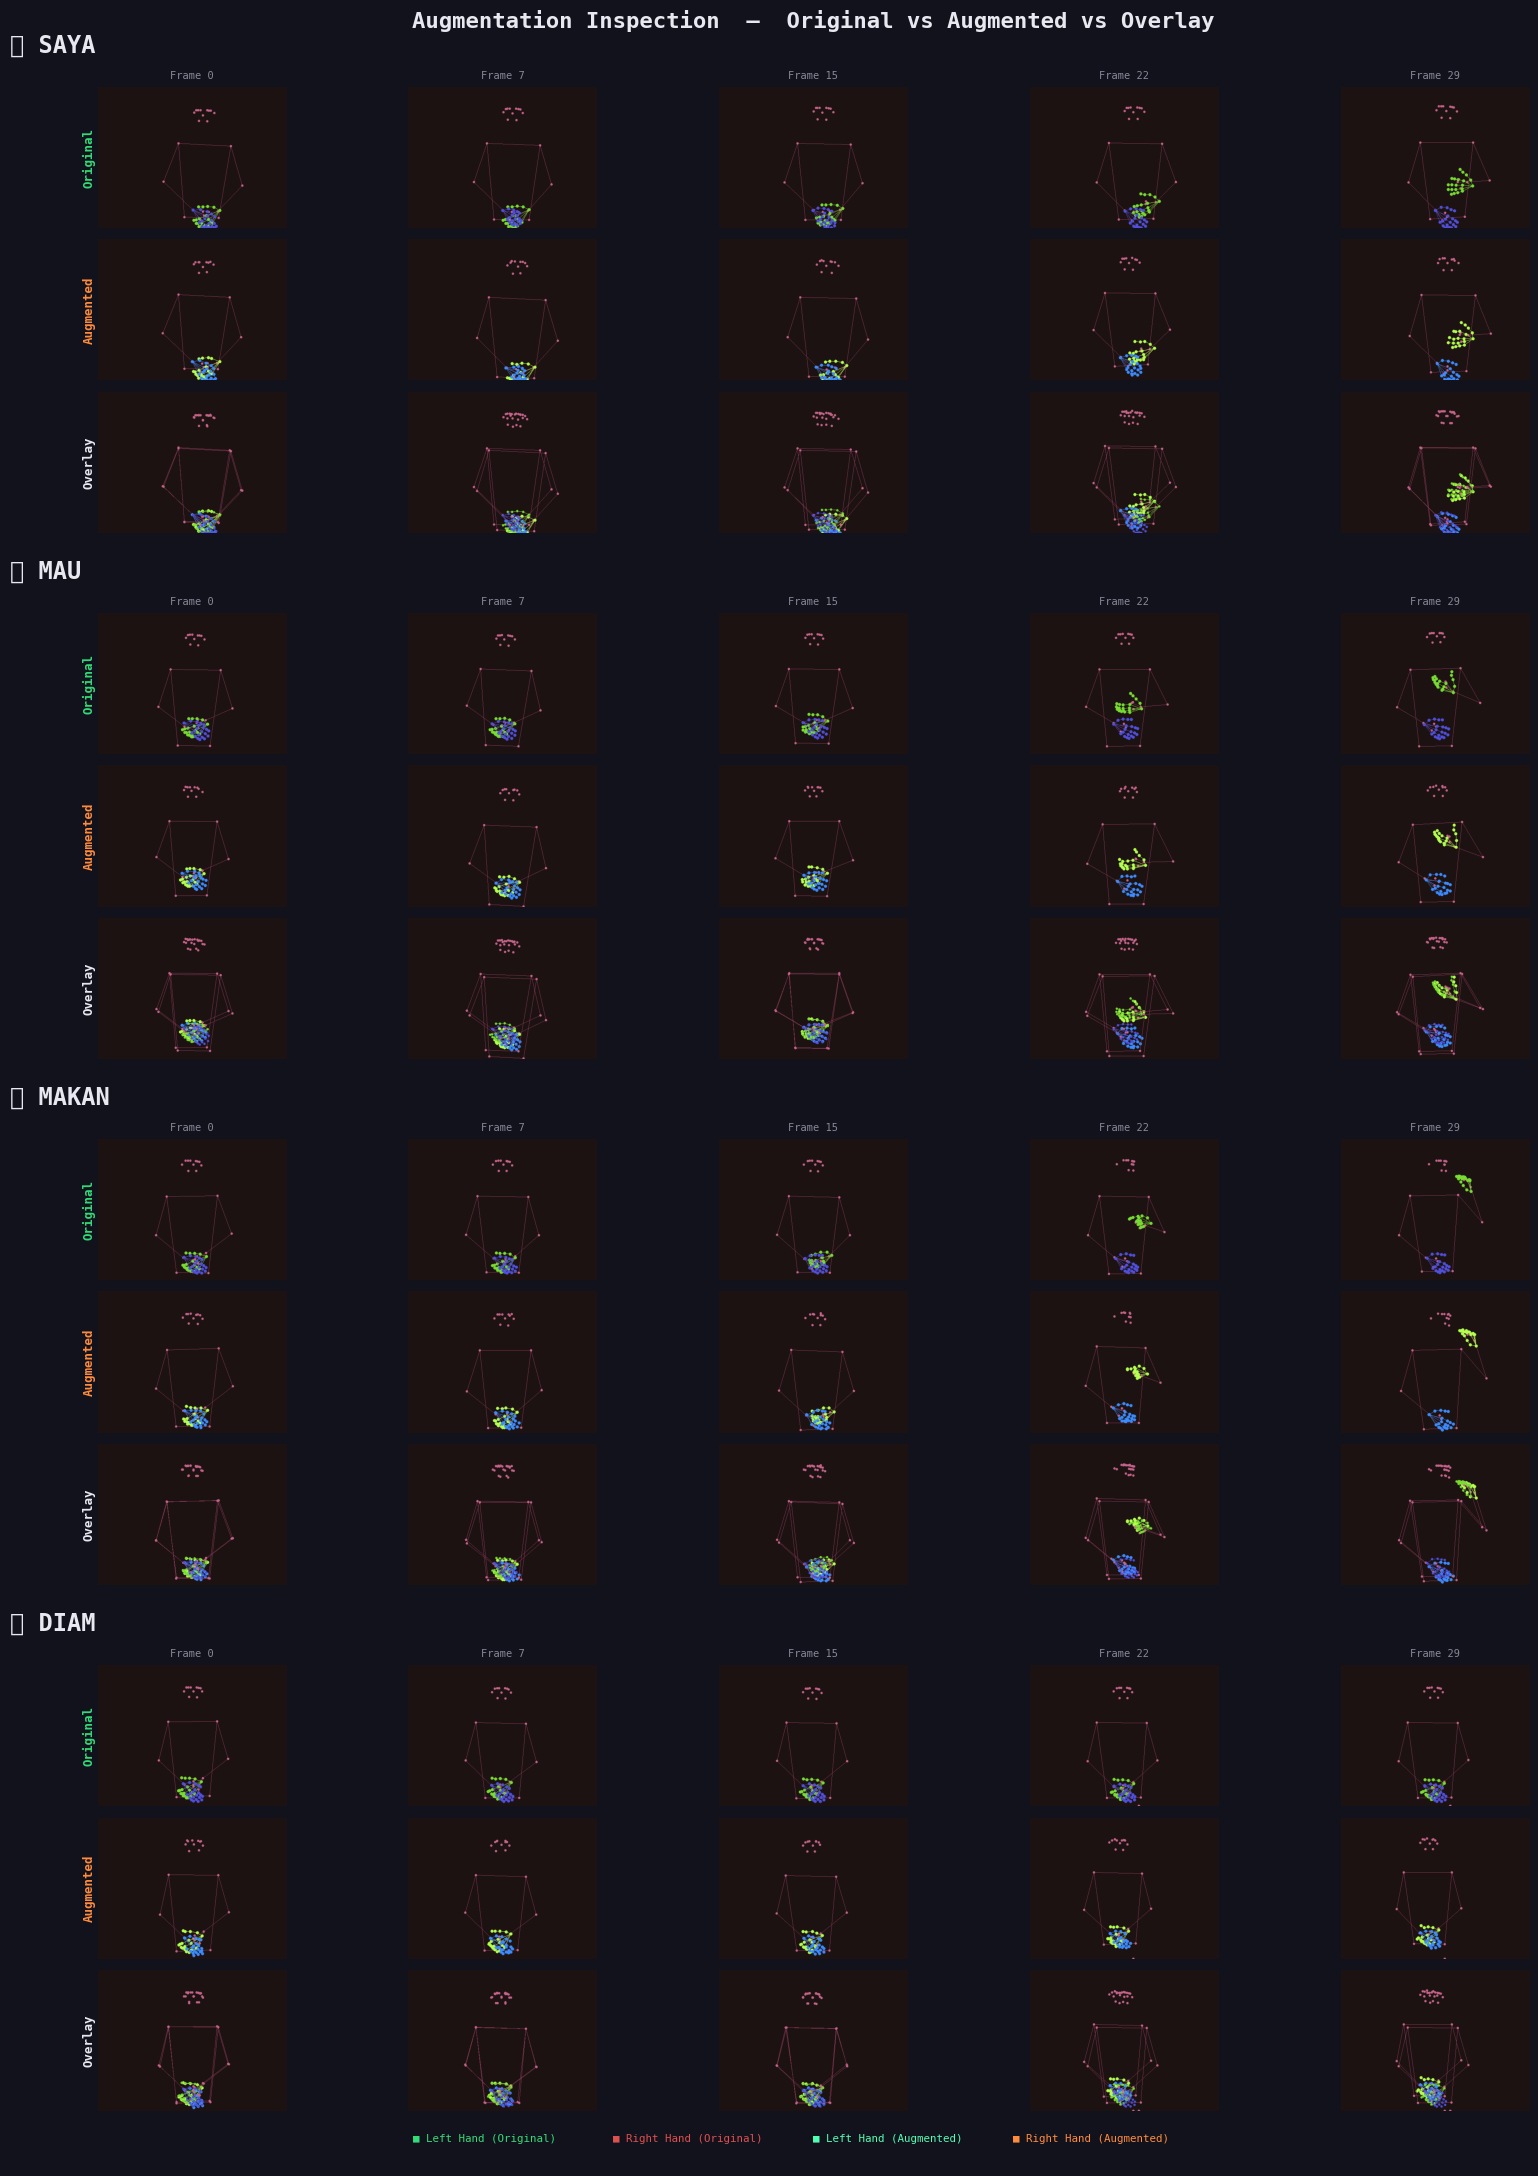

💾 Comparison image saved → d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata\augmentation_comparison.png
💾 GIF saved → d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata\augmentation_gif_saya.gif  (30 frames)
💾 GIF saved → d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata\augmentation_gif_mau.gif  (30 frames)
💾 GIF saved → d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata\augmentation_gif_makan.gif  (30 frames)
💾 GIF saved → d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata\augmentation_gif_diam.gif  (30 frames)

📊 ANIMATED GIF — Augmentation per Action


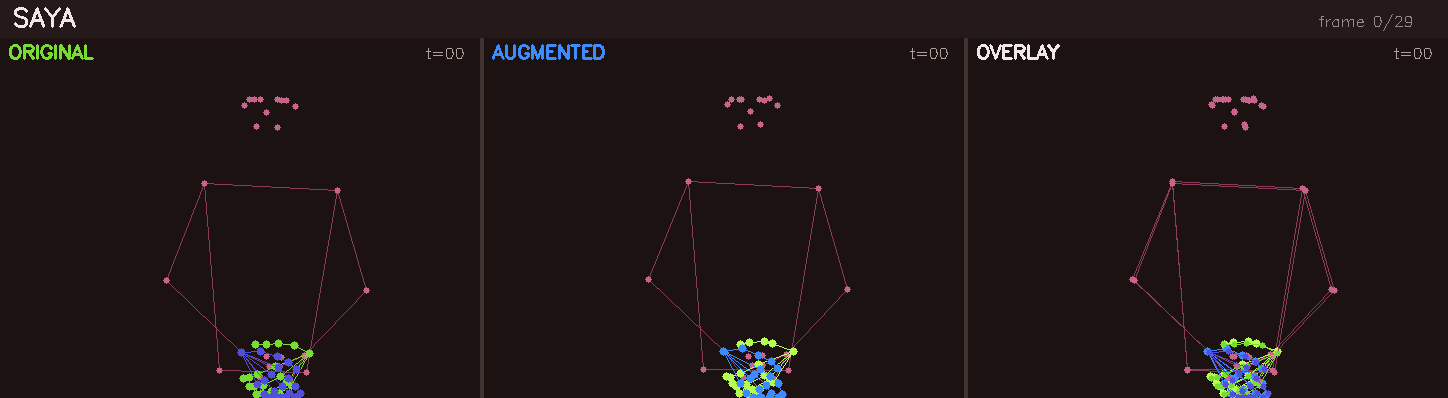

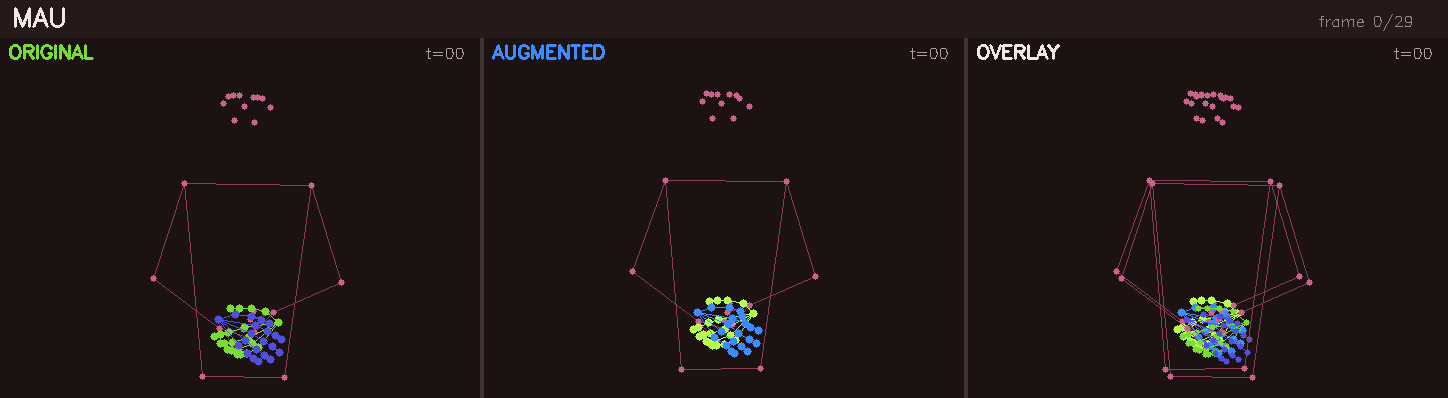

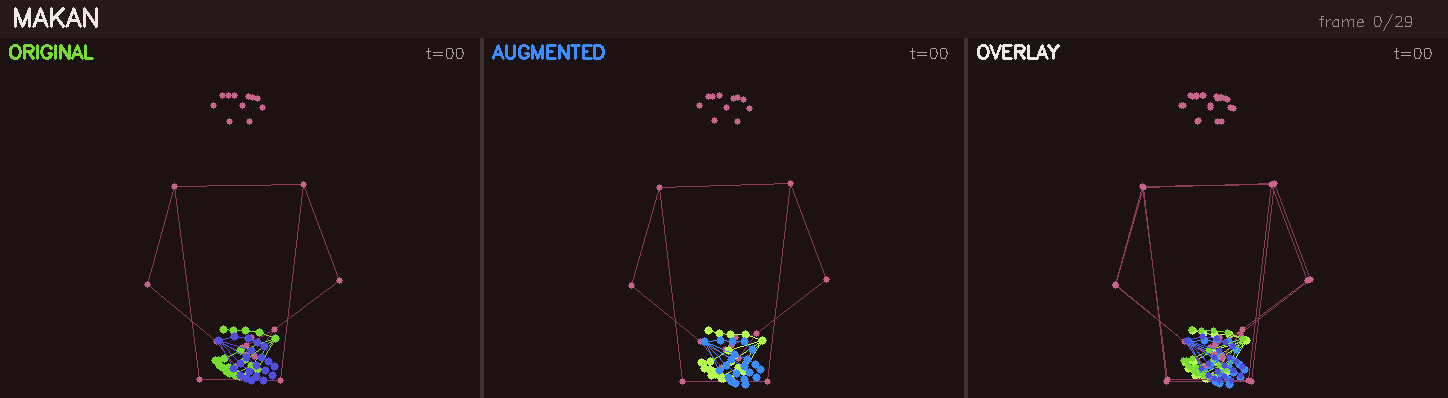

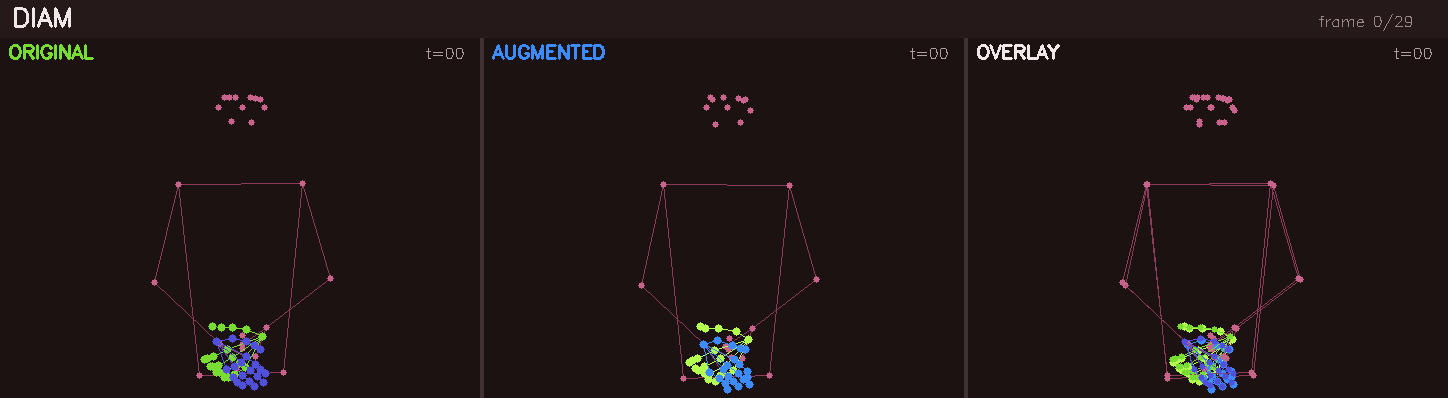


📈 STATISTIK PERBANDINGAN AUGMENTASI
Action       Metric                     Original    Augmented    Δ (abs)
------------------------------------------------------------------------
saya         Mean                       0.481049     0.489673   0.008624
             Std                        0.389458     0.383554   0.005904
             Max                        1.020098     1.000000   0.020098
             Mean Δ/frame                      —            —   0.017684

mau          Mean                       0.426756     0.433993   0.007237
             Std                        0.337042     0.333079   0.003963
             Max                        0.899985     0.936972   0.036987
             Mean Δ/frame                      —            —   0.017303

makan        Mean                       0.408267     0.415124   0.006857
             Std                        0.372733     0.371696   0.001037
             Max                        0.952873     1.000000   0.047127
            

In [8]:
# ============================================================
# 🔍 INSPEKSI AUGMENTASI — paste cell ini tepat SETELAH Cell 14
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
from PIL import Image
import io, os, warnings
warnings.filterwarnings("ignore")

# ─── 1. KONFIG ────────────────────────────────────────────────
N_ACTIONS_SHOW   = min(4, len(ACTIONS))   # berapa action yang di-sample
N_AUG_VARIANTS   = 4                      # berapa versi augmentasi per sequence
FRAME_INDICES    = [0, 7, 15, 22, 29]     # frame dalam 1 sequence yang ditampilkan
CANVAS_H, CANVAS_W = 360, 480             # ukuran canvas per sub-plot

# ─── 2. BOUNDARY PARSER (sesuai extract_keypoints_with_motion) ─
POSE_END  = 33 * 4          # 132
FACE_END  = POSE_END + 468 * 3  # 1536
LH_END    = FACE_END + 21 * 3   # 1599
RH_END    = LH_END  + 21 * 3    # 1662

# ─── 3. COLOUR PALETTE ────────────────────────────────────────
C_BG        = (18, 18, 28)          # dark canvas
C_GRID      = (40, 40, 55)          # grid lines
C_POSE      = (140, 100, 200)       # pose dots (purple)
C_POSE_CON  = (90, 60, 140)         # pose connections
C_LH_ORIG   = (50, 220, 120)        # left-hand original (green)
C_RH_ORIG   = (220, 80, 80)         # right-hand original (red)
C_LH_AUG    = (80, 255, 180)        # left-hand augmented (bright cyan-green)
C_RH_AUG    = (255, 140, 60)        # right-hand augmented (bright orange)
C_OVERLAY_ORIG = (255, 255, 255, 140)   # white semi-transparent (RGBA)
C_OVERLAY_AUG  = (255, 230, 50, 140)    # yellow semi-transparent

# POSE connections (subset yang paling visible untuk hand-sign)
POSE_CONN = [
    (11,12),(11,13),(12,14),(13,15),(14,16),   # arms
    (11,23),(12,24),(23,24),                   # shoulders-hips
    (15,17),(15,19),(16,18),(16,20),           # wrists-fingers
]
# Left-hand finger connections  (21-joint hand)
HAND_CONN = [
    (0,1),(1,2),(2,3),(3,4),          # thumb
    (0,5),(5,6),(6,7),(7,8),          # index
    (0,9),(9,10),(10,11),(11,12),     # middle
    (0,13),(13,14),(14,15),(15,16),   # ring
    (0,17),(17,18),(18,19),(19,20),   # pinky
]

# ─── 4. FUNGSI DRAW ──────────────────────────────────────────
def _parse_kp(kp):
    """Kembalikan dict pose / lh / rh sebagai array (N, 2) pixel-space."""
    pose_raw = kp[:POSE_END].reshape(-1, 4)            # x,y,z,vis
    lh_raw   = kp[FACE_END:LH_END].reshape(-1, 3)     # x,y,z
    rh_raw   = kp[LH_END:RH_END].reshape(-1, 3)       # x,y,z
    return pose_raw, lh_raw, rh_raw

def _to_px(xyz, h, w):
    """(x,y,...) → pixel (col, row), clip ke canvas."""
    return (int(np.clip(xyz[0]*w, 0, w-1)),
            int(np.clip(xyz[1]*h, 0, h-1)))

def _draw_connections(canvas, pts, connections, color, thickness=1):
    for a, b in connections:
        if np.allclose(pts[a][:2], 0) or np.allclose(pts[b][:2], 0):
            continue
        cv2.line(canvas, _to_px(pts[a], canvas.shape[0], canvas.shape[1]),
                          _to_px(pts[b], canvas.shape[0], canvas.shape[1]),
                 color, thickness)

def _draw_hand(canvas, hand_pts, color_dot, color_line, dot_r=4):
    _draw_connections(canvas, hand_pts, HAND_CONN, color_line, 1)
    for pt in hand_pts:
        if np.allclose(pt[:2], 0):
            continue
        cv2.circle(canvas, _to_px(pt, canvas.shape[0], canvas.shape[1]),
                   dot_r, color_dot, -1)

def _draw_pose(canvas, pose_pts, color_dot, color_line, dot_r=3):
    # connections
    for a, b in POSE_CONN:
        if pose_pts[a][3] < 0.3 or pose_pts[b][3] < 0.3:
            continue
        cv2.line(canvas, _to_px(pose_pts[a], canvas.shape[0], canvas.shape[1]),
                          _to_px(pose_pts[b], canvas.shape[0], canvas.shape[1]),
                 color_line, 1)
    # dots
    for pt in pose_pts:
        if pt[3] < 0.3:
            continue
        cv2.circle(canvas, _to_px(pt, canvas.shape[0], canvas.shape[1]),
                   dot_r, color_dot, -1)

def render_skeleton(kp, h=CANVAS_H, w=CANVAS_W, mode="original"):
    """
    mode='original' → green/red  |  mode='augmented' → cyan-green/orange
    mode='overlay'  → semitransparent original + augmented (RGBA)
    """
    use_rgba = (mode == "overlay")
    canvas = np.zeros((h, w, 4 if use_rgba else 3), dtype=np.uint8)
    # background
    canvas[:, :, :3] = C_BG

    pose, lh, rh = _parse_kp(kp)

    if mode == "original":
        _draw_pose(canvas, pose, C_POSE, C_POSE_CON)
        _draw_hand(canvas, lh, C_LH_ORIG, C_LH_ORIG)
        _draw_hand(canvas, rh, C_RH_ORIG, C_RH_ORIG)
    elif mode == "augmented":
        _draw_pose(canvas, pose, C_POSE, C_POSE_CON)
        _draw_hand(canvas, lh, C_LH_AUG, C_LH_AUG)
        _draw_hand(canvas, rh, C_RH_AUG, C_RH_AUG)
    elif mode == "overlay":
        # augmented layer first (background)
        _draw_pose(canvas, pose, C_POSE, C_POSE_CON)
        _draw_hand(canvas, lh, C_LH_AUG, C_LH_AUG, dot_r=5)
        _draw_hand(canvas, rh, C_RH_AUG, C_RH_AUG, dot_r=5)
    return canvas

def render_overlay(kp_orig, kp_aug, h=CANVAS_H, w=CANVAS_W):
    """Gambar original (semi-transparan) di atas augmented."""
    base = render_skeleton(kp_aug, h, w, mode="augmented")  # BGR
    # Gambar original di atas
    pose_o, lh_o, rh_o = _parse_kp(kp_orig)
    _draw_pose(base, pose_o, C_POSE, C_POSE_CON)
    _draw_hand(base, lh_o, C_LH_ORIG, C_LH_ORIG, dot_r=3)
    _draw_hand(base, rh_o, C_RH_ORIG, C_RH_ORIG, dot_r=3)
    return base   # BGR

# ─── 5. LOAD ONE SEQUENCE PER ACTION ──────────────────────────
def _load_sequence(action, seq_idx=0):
    """Load urutan .npy dari DATA_PATH / action / seq_idx."""
    seq_dir = DATA_PATH / action / str(seq_idx)
    if not seq_dir.exists():
        return None
    frames = []
    for t in range(SEQUENCE_LENGTH):
        p = seq_dir / f"{t}.npy"
        if not p.exists():
            return None
        frames.append(np.load(p))
    return np.array(frames)   # (30, 1662)  — only raw keypoints

sampled = {}   # { action : ndarray (30, 1662) }
for act in ACTIONS[:N_ACTIONS_SHOW]:
    seq = _load_sequence(act, seq_idx=0)
    if seq is not None:
        sampled[act] = seq
    else:
        print(f"⚠️  Tidak bisa load sequence untuk '{act}' — dilewati.")

if not sampled:
    raise RuntimeError("Tidak ada sequence yang berhasil di-load. "
                       "Jalankan process_videos_with_motion() dulu.")

# ─── 6. GENERATE AUGMENTED VARIANTS ──────────────────────────
np.random.seed(42)
augmented_variants = {}   # { action : list of N_AUG_VARIANTS arrays (30,1662) }
for act, orig_seq in sampled.items():
    variants = []
    for _ in range(N_AUG_VARIANTS):
        aug_seq = np.array([augment_keypoints_improved(kp[:1662]) for kp in orig_seq])
        variants.append(aug_seq)
    augmented_variants[act] = variants

print(f"✅ Loaded {len(sampled)} actions × {N_AUG_VARIANTS} augmentation variants")

# ─── 7. GAMBAR 1 — COMPARISON GRID (static PNG) ──────────────
#   Layout per action:
#     Baris 0  : Original   (5 frame)
#     Baris 1  : Augmented  (5 frame, variant pertama)
#     Baris 2  : Overlay    (original di atas augmented, semi-transparan)

n_acts   = len(sampled)
n_frames = len(FRAME_INDICES)

fig = plt.figure(figsize=(n_frames * 3.2, n_acts * 5.5), facecolor="#12121c")

# Outer grid: satu baris per action
outer_gs = gridspec.GridSpec(n_acts, 1, hspace=0.18,
                             left=0.02, right=0.98, top=0.95, bottom=0.03)

color_legend = {
    "Left Hand (Original)":  "#32dc78",
    "Right Hand (Original)": "#dc5050",
    "Left Hand (Augmented)": "#50ffb4",
    "Right Hand (Augmented)":"#ff8c3c",
}

for row, (act, orig_seq) in enumerate(sampled.items()):
    aug_seq = augmented_variants[act][0]   # variant pertama

    # Inner grid: 3 sub-baris (orig / aug / overlay) x n_frames kolom
    inner_gs = gridspec.GridSpecFromSubplotSpec(
        3, n_frames, subplot_spec=outer_gs[row],
        hspace=0.08, wspace=0.06)

    # — Judul action ————
    ax_title = fig.add_subplot(inner_gs[0, 0])
    ax_title.set_axis_off()
    ax_title.text(-0.12, 1.38, f"🤚 {act.upper()}",
                  transform=ax_title.transAxes,
                  fontsize=17, fontweight="bold", color="#e8e8f0",
                  verticalalignment="top", family="monospace")

    row_labels = ["Original", "Augmented", "Overlay"]
    row_colors = ["#32dc78", "#ff8c3c", "#e8e8f0"]

    for sub_row in range(3):
        for col, fi in enumerate(FRAME_INDICES):
            ax = fig.add_subplot(inner_gs[sub_row, col])
            ax.set_axis_off()

            if sub_row == 0:
                img = render_skeleton(orig_seq[fi], mode="original")
            elif sub_row == 1:
                img = render_skeleton(aug_seq[fi], mode="augmented")
            else:
                img = render_overlay(orig_seq[fi], aug_seq[fi])

            # OpenCV BGR → RGB for matplotlib
            ax.imshow(img[:, :, ::-1] if img.shape[2] == 3 else img[:, :, :3])

            # Label baris (hanya kolom pertama)
            if col == 0:
                ax.text(-0.08, 0.5, row_labels[sub_row],
                        transform=ax.transAxes, fontsize=9,
                        color=row_colors[sub_row], fontweight="bold",
                        verticalalignment="center", rotation=90,
                        family="monospace")

            # Label frame (hanya baris pertama)
            if sub_row == 0:
                ax.text(0.5, 1.06, f"Frame {fi}",
                        transform=ax.transAxes, fontsize=7.5,
                        color="#888899", ha="center", family="monospace")

# — Legend global (bawah) ───────────────────────────────
ax_leg = fig.add_axes([0.25, 0.005, 0.5, 0.025])
ax_leg.set_axis_off()
legend_txt = "   |   ".join(
    [f"■ {name}" for name in color_legend]
)
# warna per segmen
segments = list(color_legend.items())
x_pos = 0.0
for name, clr in segments:
    ax_leg.text(x_pos, 0.5, f"■ {name}",
                transform=ax_leg.transAxes, fontsize=7.8,
                color=clr, verticalalignment="center", family="monospace")
    x_pos += 0.25

# — Judul utama ─────────────────────────────────────────
fig.suptitle("Augmentation Inspection  —  Original vs Augmented vs Overlay",
             fontsize=16, color="#e8e8f0", y=0.985, fontweight="bold",
             fontfamily="monospace")

comp_path = str(PROJECT_ROOT / "augmentation_comparison.png")
plt.savefig(comp_path, dpi=150, bbox_inches="tight", facecolor="#12121c")
plt.show()
print(f"💾 Comparison image saved → {comp_path}")

# ─── 8. GAMBAR 2 — ANIMATED GIF (per action) ─────────────────
#   Setiap GIF: loop frame 0-29, setiap frame menampilkan 3 panel:
#     [Original | Augmented | Overlay]
#   Setiap action menghasilkan 1 GIF.

from PIL import Image as PILImage

gif_duration_ms = 90   # ms per frame (≈11 fps)

for act, orig_seq in sampled.items():
    aug_seq = augmented_variants[act][0]
    frames_pil = []

    for t in range(SEQUENCE_LENGTH):
        # render 3 panel
        img_orig = render_skeleton(orig_seq[t],  mode="original")
        img_aug  = render_skeleton(aug_seq[t],   mode="augmented")
        img_ovl  = render_overlay(orig_seq[t], aug_seq[t])

        # Tambahkan label di atas masing-masing panel
        label_h = 30
        for img, label, clr in [
            (img_orig, "ORIGINAL",  (50, 220, 120)),
            (img_aug,  "AUGMENTED",(255, 140, 60)),
            (img_ovl,  "OVERLAY",  (232, 232, 240))
        ]:
            cv2.putText(img, label, (8, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.62, clr, 2)

        # Frame counter (kanan atas)
        frame_label = f"t={t:02d}"
        for img in (img_orig, img_aug, img_ovl):
            cv2.putText(img, frame_label, (CANVAS_W - 55, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (160, 160, 175), 1)

        # Divider strip (vertical, antara panel)
        divider = np.full((CANVAS_H, 4, 3), (50, 50, 65), dtype=np.uint8)

        # Gabungkan horizontal: orig | div | aug | div | ovl
        strip = np.hstack([img_orig, divider, img_aug, divider, img_ovl])

        # Header bar dengan judul action + frame
        bar_h = 38
        header = np.full((bar_h, strip.shape[1], 3), (25, 25, 38), dtype=np.uint8)
        title_txt  = f"🤚 {act.upper()}"
        cv2.putText(header, act.upper(), (12, 26),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.85, (232, 232, 240), 2)
        cv2.putText(header, f"frame {t}/{SEQUENCE_LENGTH-1}", (strip.shape[1]-130, 26),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (136, 136, 153), 1)

        full_frame = np.vstack([header, strip])   # BGR

        # BGR → RGB → PIL
        rgb = cv2.cvtColor(full_frame, cv2.COLOR_BGR2RGB)
        frames_pil.append(PILImage.fromarray(rgb))

    # Save GIF
    gif_path = str(PROJECT_ROOT / f"augmentation_gif_{act}.gif")
    frames_pil[0].save(
        gif_path,
        save_all=True,
        append_images=frames_pil[1:],
        duration=gif_duration_ms,
        loop=0
    )
    print(f"💾 GIF saved → {gif_path}  ({len(frames_pil)} frames)")

# ─── 9. TAMPILKAN GIF DI NOTEBOOK (inline) ───────────────────
from IPython.display import Image as IPImage, display, HTML

print("\n" + "="*70)
print("📊 ANIMATED GIF — Augmentation per Action")
print("="*70)
for act in sampled:
    gif_path = str(PROJECT_ROOT / f"augmentation_gif_{act}.gif")
    display(HTML(f"<h4 style='color:#ccc;font-family:monospace'>🤚 {act}</h4>"))
    display(IPImage(filename=gif_path))

# ─── 10. RINGKASAN STATISTIK AUGMENTASI ──────────────────────
print("\n" + "="*70)
print("📈 STATISTIK PERBANDINGAN AUGMENTASI")
print("="*70)
print(f"{'Action':<12} {'Metric':<22} {'Original':>12} {'Augmented':>12} {'Δ (abs)':>10}")
print("-" * 72)

for act, orig_seq in sampled.items():
    aug_seq = augmented_variants[act][0]
    # Hanya bandingkan bagian hand (LH + RH) — paling relevan
    orig_hands = orig_seq[:, FACE_END:RH_END]   # (30, 126)
    aug_hands  = aug_seq[:, FACE_END:RH_END]

    metrics = {
        "Mean"       : (orig_hands.mean(), aug_hands.mean()),
        "Std"        : (orig_hands.std(),  aug_hands.std()),
        "Max"        : (orig_hands.max(),  aug_hands.max()),
        "Mean Δ/frame": (np.abs(orig_hands - aug_hands).mean(axis=1).mean(),
                         0.0),   # referensi = 0
    }
    first = True
    for mname, (ov, av) in metrics.items():
        prefix = f"{act:<12}" if first else " " * 12
        first  = False
        if mname == "Mean Δ/frame":
            print(f"{prefix} {mname:<22} {'—':>12} {'—':>12} {ov:>10.6f}")
        else:
            print(f"{prefix} {mname:<22} {ov:>12.6f} {av:>12.6f} {abs(ov-av):>10.6f}")
    print()

print("✅ Inspeksi augmentasi selesai.")

## 7. Build dataset (X, y)

In [9]:
# ===== CELL 7: DATASET LOADER (20 frame) =====
sequences, labels = [], []
for action in ACTIONS:
    action_dir = DATA_PATH / action
    if not action_dir.exists():
        print(f"⚠️ {action_dir} not found"); continue
    video_folders = sorted([d for d in action_dir.iterdir() if d.is_dir()], key=lambda x: int(x.name))
    print(f"📁 Loading {len(video_folders)} sequences for action '{action}'")
    for folder in video_folders:
        window = []
        for t in range(SEQUENCE_LENGTH):
            npy_file = folder/f"{t}.npy"
            if not npy_file.exists():
                print(f"  ⚠️ missing {npy_file}"); break
            window.append(np.load(npy_file))
        if len(window) == SEQUENCE_LENGTH:
            sequences.append(window)
            labels.append(label_map[action])
X = np.array(sequences)
y = to_categorical(labels).astype(int)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = {i: class_weights[i] for i in range(len(ACTIONS))}

print("\n📊 Class weights untuk balancing:")
for idx, action in enumerate(ACTIONS):
    print(f"   {action}: {class_weight_dict[idx]:.2f}")
print(f"\n✅ Dataset loaded!  X: {X.shape}   y: {y.shape}")
print(f"\n📊 Label distribution:")
label_dist = pd.Series(labels).value_counts().sort_index()
for idx, count in label_dist.items():
    print(f"   {ACTIONS[idx]}: {count} sequences")



📁 Loading 300 sequences for action 'saya'
📁 Loading 308 sequences for action 'mau'
📁 Loading 300 sequences for action 'makan'
📁 Loading 298 sequences for action 'diam'
📁 Loading 432 sequences for action 'kamu'
📁 Loading 451 sequences for action 'siapa'
📁 Loading 444 sequences for action 'tolong'
📁 Loading 454 sequences for action 'apa'
📁 Loading 781 sequences for action 'kenalkan'
📁 Loading 459 sequences for action 'nama'

📊 Class weights untuk balancing:
   saya: 1.41
   mau: 1.37
   makan: 1.41
   diam: 1.42
   kamu: 0.98
   siapa: 0.94
   tolong: 0.95
   apa: 0.93
   kenalkan: 0.54
   nama: 0.92

✅ Dataset loaded!  X: (4227, 30, 1662)   y: (4227, 10)

📊 Label distribution:
   saya: 300 sequences
   mau: 308 sequences
   makan: 300 sequences
   diam: 298 sequences
   kamu: 432 sequences
   siapa: 451 sequences
   tolong: 444 sequences
   apa: 454 sequences
   kenalkan: 781 sequences
   nama: 459 sequences


In [10]:

# ===== TAMBAHAN: Fungsi untuk verifikasi struktur data =====
def verify_data_structure():
    """Fungsi untuk memverifikasi struktur data yang tersimpan"""
    print("\n🔍 Data Structure Verification:")
    print(f"{'='*60}")
    
    for action in ACTIONS:
        action_dir = DATA_PATH / action
        
        if not action_dir.exists():
            print(f"❌ {action}: Folder tidak ditemukan")
            continue
        
        video_folders = sorted([d for d in action_dir.iterdir() if d.is_dir()], 
                              key=lambda x: int(x.name))
        
        print(f"\n📁 Action: {action}")
        print(f"   Total video sequences: {len(video_folders)}")
        
        # Cek beberapa sample
        samples_to_check = min(3, len(video_folders))
        for i in range(samples_to_check):
            folder = video_folders[i]
            frames = list(folder.glob("*.npy"))
            print(f"   └─ Sequence {folder.name}: {len(frames)} frames")
            
            # Verifikasi frame lengkap
            if len(frames) != SEQUENCE_LENGTH:
                print(f"      ⚠️ Warning: Expected {SEQUENCE_LENGTH}, got {len(frames)}")
        
        if len(video_folders) > samples_to_check:
            print(f"   └─ ... and {len(video_folders) - samples_to_check} more sequences")
    
    print(f"\n{'='*60}")


verify_data_structure()


🔍 Data Structure Verification:

📁 Action: saya
   Total video sequences: 300
   └─ Sequence 0: 30 frames
   └─ Sequence 1: 30 frames
   └─ Sequence 2: 30 frames
   └─ ... and 297 more sequences

📁 Action: mau
   Total video sequences: 308
   └─ Sequence 0: 30 frames
   └─ Sequence 1: 30 frames
   └─ Sequence 2: 30 frames
   └─ ... and 305 more sequences

📁 Action: makan
   Total video sequences: 300
   └─ Sequence 0: 30 frames
   └─ Sequence 1: 30 frames
   └─ Sequence 2: 30 frames
   └─ ... and 297 more sequences

📁 Action: diam
   Total video sequences: 298
   └─ Sequence 0: 30 frames
   └─ Sequence 1: 30 frames
   └─ Sequence 2: 30 frames
   └─ ... and 295 more sequences

📁 Action: kamu
   Total video sequences: 432
   └─ Sequence 0: 30 frames
   └─ Sequence 1: 30 frames
   └─ Sequence 2: 30 frames
   └─ ... and 429 more sequences

📁 Action: siapa
   Total video sequences: 451
   └─ Sequence 0: 30 frames
   └─ Sequence 1: 30 frames
   └─ Sequence 2: 30 frames
   └─ ... and 448 more

## 8. Train / test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,      
    random_state=SEED,
    stratify=labels      # ⬅️ PENTING: pastikan distribusi seimbang
)

print(f"\n📦 Dataset split:")
print(f"   Training:   {X_train.shape[0]} sequences")
print(f"   Testing:    {X_test.shape[0]} sequences")
print(f"\n   Train class distribution:")
train_labels = np.argmax(y_train, axis=1)
for idx, action in enumerate(ACTIONS):
    count = np.sum(train_labels == idx)
    print(f"   {action}: {count} sequences")


📦 Dataset split:
   Training:   3170 sequences
   Testing:    1057 sequences

   Train class distribution:
   saya: 225 sequences
   mau: 231 sequences
   makan: 225 sequences
   diam: 224 sequences
   kamu: 324 sequences
   siapa: 338 sequences
   tolong: 333 sequences
   apa: 340 sequences
   kenalkan: 586 sequences
   nama: 344 sequences


## 9. Build LSTM model (unchanged architecture)

In [12]:
# ===== OPSI 2: Bidirectional LSTM (Lebih powerful) =====


model = Sequential([
    # Layer 1 - Bidirectional
    Bidirectional(LSTM(256, return_sequences=True, 
                       kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
                  input_shape=(SEQUENCE_LENGTH, X.shape[2])),
    LayerNormalization(),
    SpatialDropout1D(0.3),
    
    # Layer 2 - Bidirectional
    Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
    LayerNormalization(),
    SpatialDropout1D(0.3),
    
    # Layer 3 - Bidirectional
    Bidirectional(LSTM(64, return_sequences=False,
                       kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
    LayerNormalization(),
    Dropout(0.4),
    
    # Dense layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(ACTIONS), activation='softmax')
])

# Optimizer dengan learning rate rendah
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Lebih rendah!

model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy', 
    metrics=['categorical_accuracy']
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 30, 512)           3930112   
 al)                                                             
                                                                 
 layer_normalization (Layer  (None, 30, 512)           1024      
 Normalization)                                                  
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 512)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 256)           656384    
 onal)                                                           
                                                                 
 layer_normalization_1 (Lay  (None, 30, 256)          

## 10. Train with callbacks

In [13]:
# Data generator untuk augmentation real-time
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=16, shuffle=True, augment=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(X))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[indexes].copy()
        y_batch = self.y[indexes]
        
        # Augment 50% data saat training
        if self.augment:
            for i in range(len(X_batch)):
                if np.random.rand() > 0.5:
                    # Apply noise ke setiap frame
                    for t in range(X_batch.shape[1]):
                        # Hanya augment keypoints, jangan velocity/acceleration
                        n_features = 1662
                        X_batch[i, t, :n_features] = augment_keypoints_improved(
                            X_batch[i, t, :n_features]
                        )
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Split validation
val_size = int(0.15 * len(X_train))
X_val = X_train[:val_size]
y_val = y_train[:val_size]
X_train_final = X_train[val_size:]
y_train_final = y_train[val_size:]

# Generators
train_gen = DataGenerator(X_train_final, y_train_final, 
                          batch_size=16, augment=True)
val_gen = DataGenerator(X_val, y_val, batch_size=16, augment=False)

# Callbacks
callbacks = [
    TensorBoard(log_dir=LOG_PATH),
    
    EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    
    ModelCheckpoint(
        str(MODEL_PATH),
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200


169/169 [==============================] - ETA: 0s - loss: 51.7726 - categorical_accuracy: 0.1091
Epoch 1: val_categorical_accuracy improved from -inf to 0.09684, saving model to d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata\my_model.keras
169/169 [==============================] - 48s 212ms/step - loss: 51.7726 - categorical_accuracy: 0.1091 - val_loss: 46.6218 - val_categorical_accuracy: 0.0968 - lr: 1.0000e-04
Epoch 2/200
169/169 [==============================] - ETA: 0s - loss: 43.3447 - categorical_accuracy: 0.1147
Epoch 2: val_categorical_accuracy improved from 0.09684 to 0.19368, saving model to d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata\my_model.keras
169/169 [==============================] - 34s 200ms/step - loss: 43.3447 - categorical_accuracy: 0.1147 - val_loss: 39.8168 - val_categorical_accuracy: 0.1937 - lr: 1.0000e-04
Epoch 3/200
169/169 [====================

## 11. Evaluate

34/34 [==============================] - 3s 46ms/step
Accuracy: 0.9754020813623463

Classification report:
              precision    recall  f1-score   support

        saya       0.92      0.89      0.91        75
         mau       0.90      0.92      0.91        77
       makan       1.00      0.97      0.99        75
        diam       0.97      1.00      0.99        74
        kamu       0.96      0.98      0.97       108
       siapa       1.00      0.97      0.99       113
      tolong       1.00      0.99      1.00       111
         apa       0.99      0.99      0.99       114
    kenalkan       0.99      0.98      0.99       195
        nama       0.97      1.00      0.99       115

    accuracy                           0.98      1057
   macro avg       0.97      0.97      0.97      1057
weighted avg       0.98      0.98      0.98      1057


Confusion Matrix (Multiclass):


,saya,mau,makan,diam,kamu,siapa,tolong,apa,kenalkan,nama
saya,67,7,0,1,0,0,0,0,0,0
mau,6,71,0,0,0,0,0,0,0,0
makan,0,1,73,1,0,0,0,0,0,0
diam,0,0,0,74,0,0,0,0,0,0
kamu,0,0,0,0,106,0,0,0,2,0
siapa,0,0,0,0,2,110,0,1,0,0
tolong,0,0,0,0,1,0,110,0,0,0
apa,0,0,0,0,1,0,0,113,0,0
kenalkan,0,0,0,0,0,0,0,0,192,3
nama,0,0,0,0,0,0,0,0,0,115


📊 ANALISIS PERFORMANCE MODEL
Training Accuracy:   0.9610  (key: categorical_accuracy)
Validation Accuracy: 0.9705  (key: val_categorical_accuracy)
Accuracy Gap:        -0.0095
Training Loss:       0.356203
Validation Loss:     0.324127
Loss Gap:            -0.032076
------------------------------------------------------------
✅ STATUS: WELL-FITTED
   Model memiliki performa dan generalisasi yang baik.


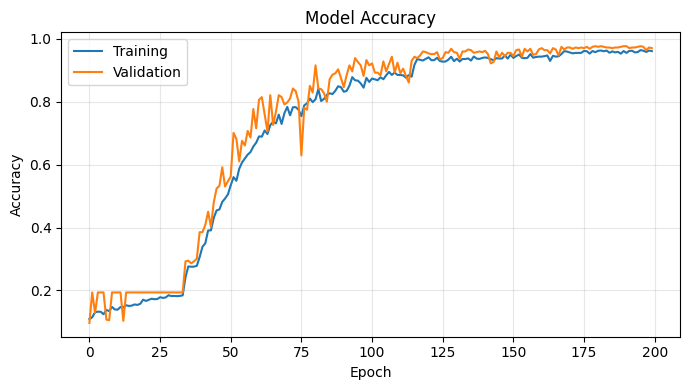

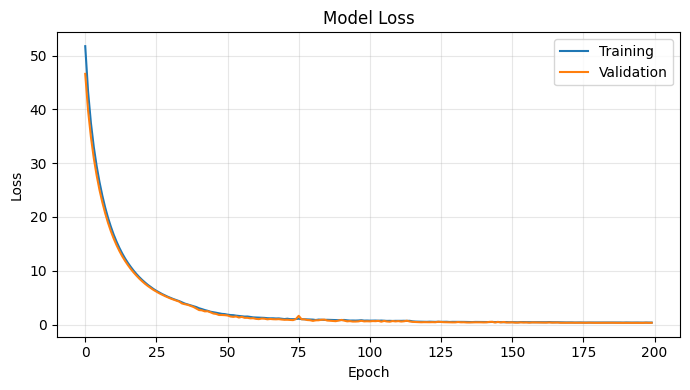

In [14]:
# Prediksi
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)        # true class index
y_pred_classes = np.argmax(y_pred, axis=1) # predicted class index

print("Accuracy:", accuracy_score(y_true, y_pred_classes))
print("\nClassification report:")
print(classification_report(y_true, y_pred_classes, target_names=ACTIONS))

# Confusion matrix multi-class (ACTIONS x ACTIONS)
cm = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(ACTIONS)))
cm_df = pd.DataFrame(cm, index=ACTIONS, columns=ACTIONS)

print("\nConfusion Matrix (Multiclass):")
display(cm_df)


def _pick_first_key(dct, candidates):
    """Ambil key pertama yang tersedia dari candidates."""
    for k in candidates:
        if k in dct:
            return k
    return None

def analyze_training_performance(history):
    """
    Analisis performa training + plot, dengan auto-detect nama key metric.
    Tidak akan error walau 'accuracy' tidak ada.
    """
    h = history.history

    # Kandidat nama metric accuracy yang umum di Keras/TensorFlow
    acc_key = _pick_first_key(h, [
        'accuracy', 'acc',
        'categorical_accuracy', 'sparse_categorical_accuracy',
        'binary_accuracy'
    ])
    val_acc_key = _pick_first_key(h, [
        'val_accuracy', 'val_acc',
        'val_categorical_accuracy', 'val_sparse_categorical_accuracy',
        'val_binary_accuracy'
    ])

    loss_key = _pick_first_key(h, ['loss'])
    val_loss_key = _pick_first_key(h, ['val_loss'])

    # Ambil nilai terakhir (kalau ada)
    train_loss = h[loss_key][-1] if loss_key else None
    val_loss   = h[val_loss_key][-1] if val_loss_key else None

    train_acc = h[acc_key][-1] if acc_key else None
    val_acc   = h[val_acc_key][-1] if val_acc_key else None

    print("="*60)
    print("📊 ANALISIS PERFORMANCE MODEL")
    print("="*60)

    if train_acc is None or val_acc is None:
        print("⚠️  Metric accuracy tidak ditemukan di history.")
        print(f"   Keys yang tersedia: {list(h.keys())}")
        print("   (Kemungkinan Anda belum menambahkan metrics=['accuracy'] saat compile,")
        print("    atau metric yang tercatat bernama 'categorical_accuracy' / 'sparse_categorical_accuracy'.)")
    else:
        accuracy_gap = train_acc - val_acc
        print(f"Training Accuracy:   {train_acc:.4f}  (key: {acc_key})")
        print(f"Validation Accuracy: {val_acc:.4f}  (key: {val_acc_key})")
        print(f"Accuracy Gap:        {accuracy_gap:.4f}")

    if train_loss is not None and val_loss is not None:
        loss_gap = val_loss - train_loss
        print(f"Training Loss:       {train_loss:.6f}")
        print(f"Validation Loss:     {val_loss:.6f}")
        print(f"Loss Gap:            {loss_gap:.6f}")
    else:
        print("⚠️  Loss/val_loss tidak lengkap di history.")
        print(f"   Keys yang tersedia: {list(h.keys())}")

    print("-"*60)

    # Rekomendasi hanya jika accuracy tersedia
    if train_acc is not None and val_acc is not None:
        accuracy_gap = train_acc - val_acc

        if val_acc >= 0.85 and accuracy_gap <= 0.05:
            print("✅ STATUS: WELL-FITTED")
            print("   Model memiliki performa dan generalisasi yang baik.")
        elif train_acc >= 0.90 and accuracy_gap > 0.15:
            print("⚠️  STATUS: OVERFITTING DETECTED")
            print("   REKOMENDASI: dropout↑, L2, augmentasi, kurangi kompleksitas, early stopping.")
        elif train_acc <= 0.70 and val_acc <= 0.70:
            print("⚠️  STATUS: UNDERFITTING DETECTED")
            print("   REKOMENDASI: tambah kapasitas model, epoch↑, regularisasi↓, LR↓.")
        elif accuracy_gap > 0.05 and accuracy_gap <= 0.15:
            print("⚠️  STATUS: SLIGHT OVERFITTING")
        else:
            print("📈 STATUS: TRAINING IN PROGRESS / AMBIGUOUS")
    else:
        print("📌 STATUS: Evaluasi berbasis loss saja (karena accuracy tidak tersedia).")

    print("="*60)

    # Plot (tanpa subplot jika Anda ingin; tapi ini masih oke untuk notebook)
    import matplotlib.pyplot as plt

    # Plot accuracy (jika ada)
    if acc_key and val_acc_key:
        plt.figure(figsize=(7, 4))
        plt.plot(h[acc_key], label='Training')
        plt.plot(h[val_acc_key], label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Plot loss (jika ada)
    if loss_key and val_loss_key:
        plt.figure(figsize=(7, 4))
        plt.plot(h[loss_key], label='Training')
        plt.plot(h[val_loss_key], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
analyze_training_performance(history)


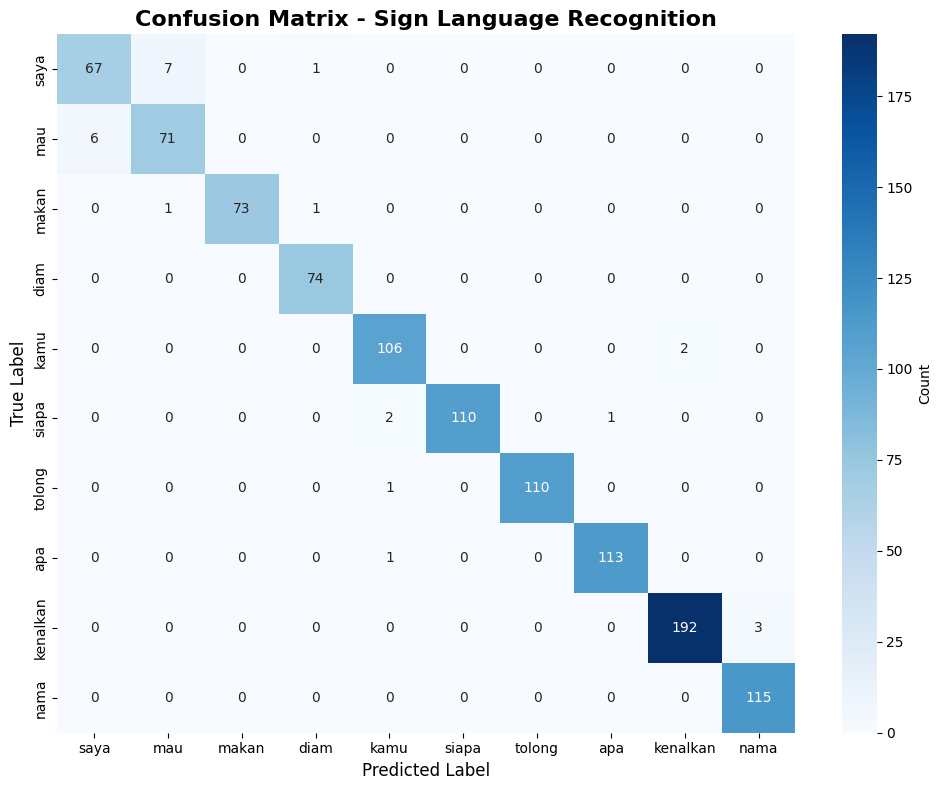

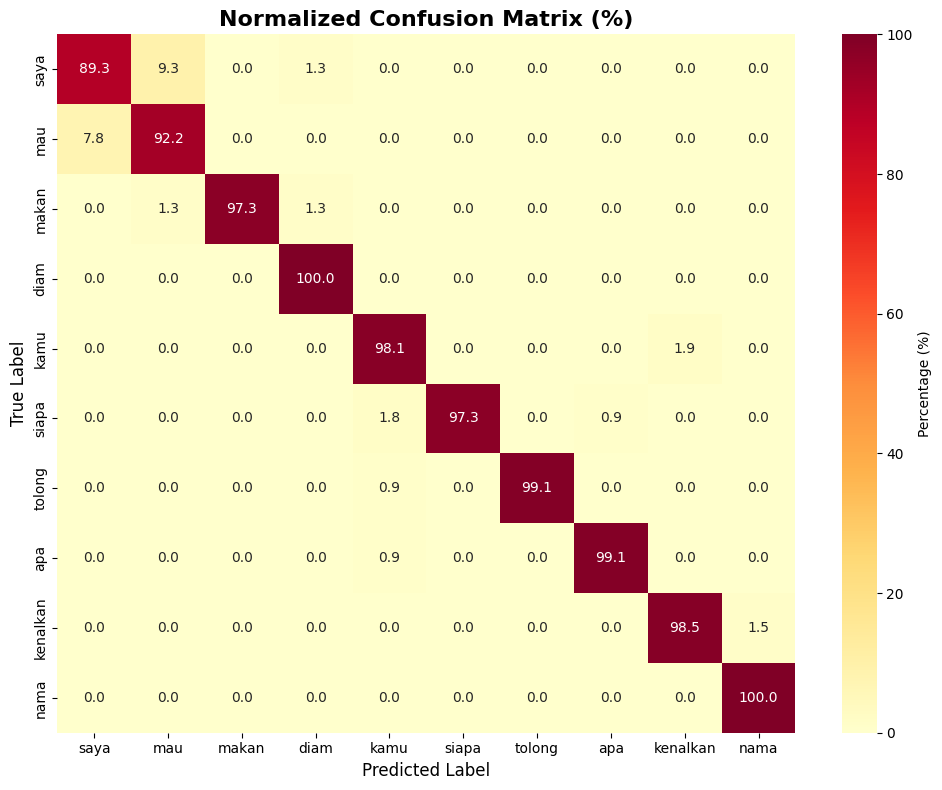

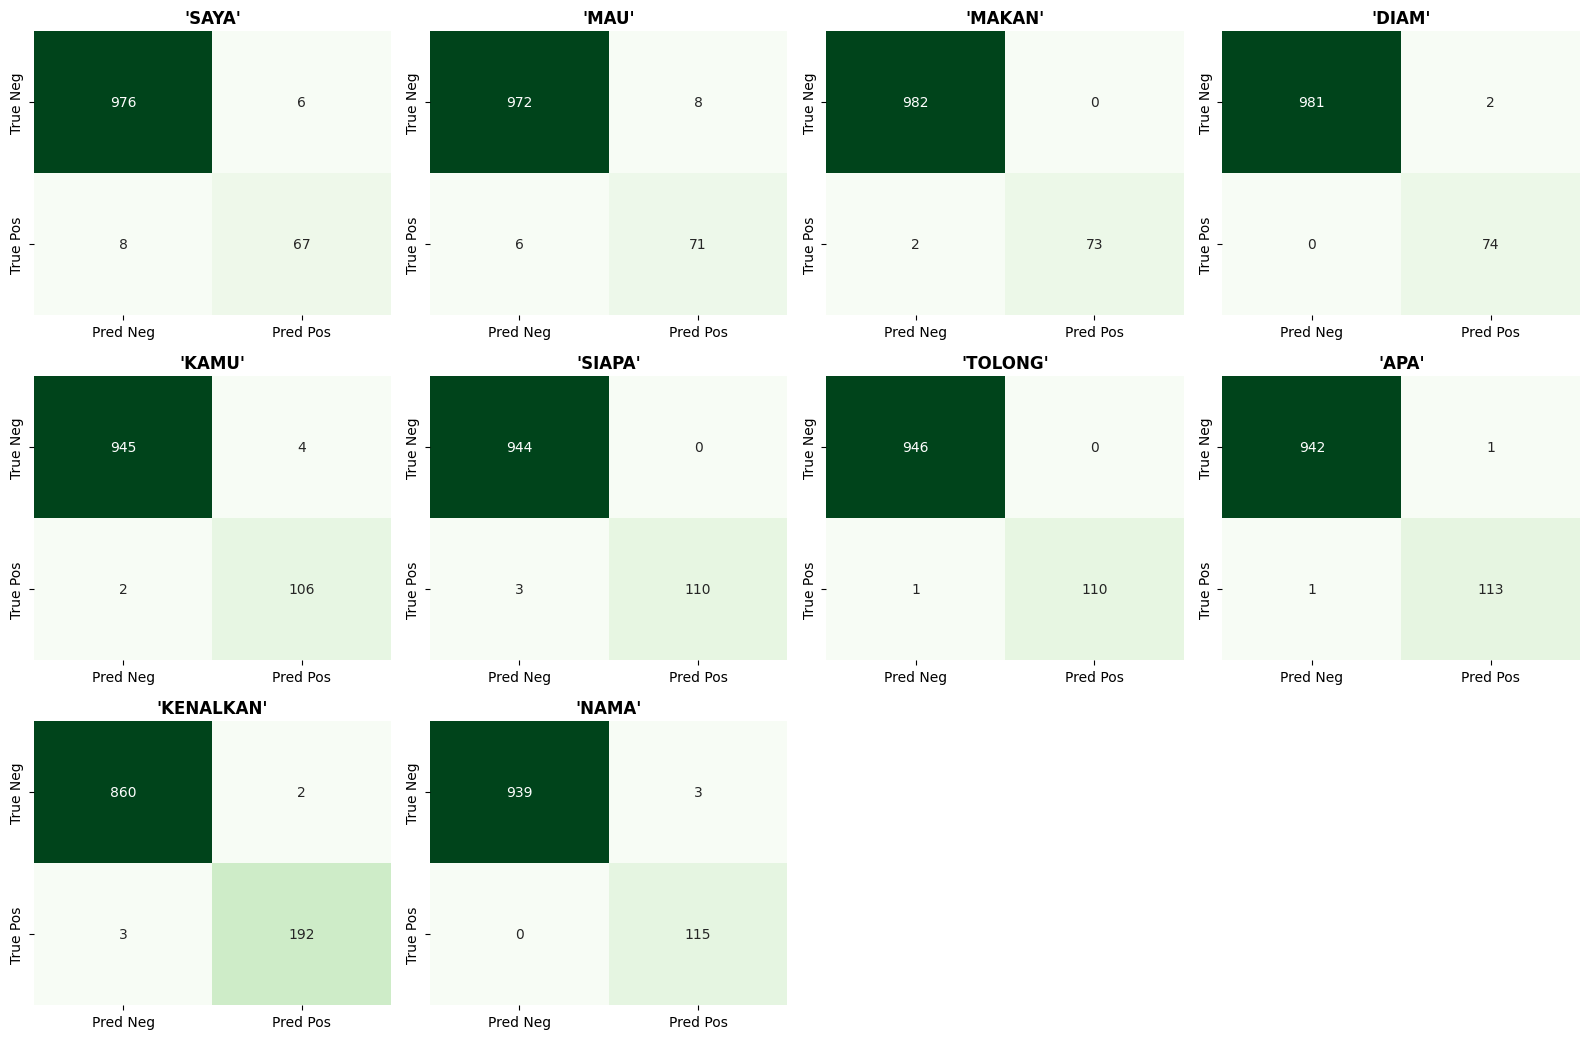


✅ Per-class confusion matrix saved to d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata


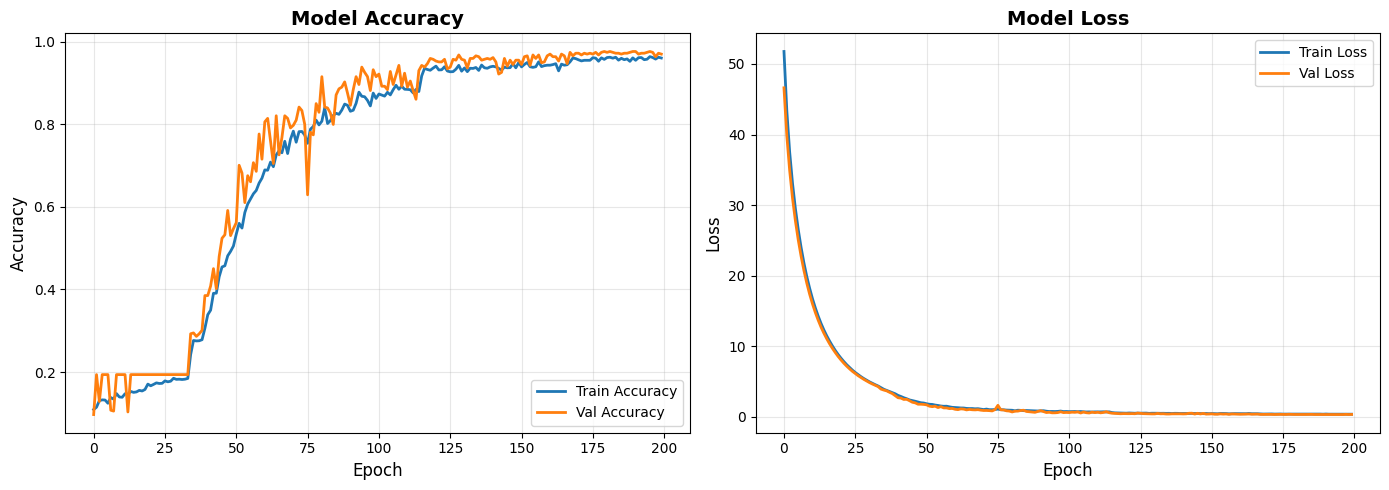

✅ Training history plot saved to d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata


In [15]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ACTIONS, yticklabels=ACTIONS,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Sign Language Recognition', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized Confusion Matrix (dalam persentase)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='YlOrRd',
            xticklabels=ACTIONS, yticklabels=ACTIONS,
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# multilabel_confusion_matrix

n_classes = len(ACTIONS)

y_true_oh = np.eye(n_classes)[y_true]           # (N, C)
y_pred_oh = np.eye(n_classes)[y_pred_classes]   # (N, C)

conf_matrix = multilabel_confusion_matrix(y_true_oh, y_pred_oh)

# grid dinamis
cols = 4  # kamu bisa ubah (misal 3 atau 5)
rows = math.ceil(n_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3.5))
axes = np.array(axes).reshape(-1)  # aman meski rows/cols = 1

for idx in range(n_classes):
    ax = axes[idx]
    matrix = conf_matrix[idx]

    sns.heatmap(
        matrix, annot=True, fmt='d', cmap='Greens',
        xticklabels=['Pred Neg', 'Pred Pos'],
        yticklabels=['True Neg', 'True Pos'],
        ax=ax, cbar=False
    )
    ax.set_title(f"'{ACTIONS[idx].upper()}'", fontsize=12, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")

# matikan axis yang tidak kepakai
for j in range(n_classes, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'confusion_matrix_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Per-class confusion matrix saved to {PROJECT_ROOT}")

# ==========================
# Plot Training History (Bonus)
# ==========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['categorical_accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_categorical_accuracy'], label='Val Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Training history plot saved to {PROJECT_ROOT}")

## 12. Save / load model

In [16]:
model.save(MODEL_PATH)
print("✅ Model saved to", MODEL_PATH)

del model
model = load_model(MODEL_PATH)
print("✅ Model reloaded")

✅ Model saved to d:\!kuliah\Tugas Akhir\sign_language_dection\sign-language-train-LSTM\sign_language_V5_12kata\my_model.keras
✅ Model reloaded


## 13. Test on a local video + overlay predictions

In [17]:
# test_video = "test_05.mp4"  # place inside TEST_PATH
# input_vid  = TEST_PATH / test_video
# output_vid = TEST_PATH / "output_6.mp4"

# if not input_vid.exists():
#     print(f"⚠  {input_vid} not found – please add a test video")
# else:
#     colors = [tuple(random.randint(0,255) for _ in range(3)) for _ in ACTIONS]

#     def prob_viz(res, input_frame, colors):
#         out = input_frame.copy()
#         for num, prob in enumerate(res):
#             cv2.rectangle(out, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
#             cv2.putText(out, ACTIONS[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
#         return out

#     cap = cv2.VideoCapture(str(input_vid))
#     w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps= cap.get(cv2.CAP_PROP_FPS)
#     out = cv2.VideoWriter(str(output_vid), cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

#     sequence, sentence, predictions = [], [], []
#     threshold = 0.5

#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret: break
#             image, results = mediapipe_detection(frame, holistic)
#             draw_styled_landmarks(image, results)
#             keypoints = extract_keypoints(results)
#             sequence.append(keypoints)
#             sequence = sequence[-30:]
#             if len(sequence) == 30:
#                 res = model.predict(np.expand_dims(sequence, axis=0))[0]
#                 predictions.append(np.argmax(res))
#                 if np.unique(predictions[-10:])[0] == np.argmax(res) and res[np.argmax(res)] > threshold:
#                     if len(sentence) == 0 or ACTIONS[np.argmax(res)] != sentence[-1]:
#                         sentence.append(ACTIONS[np.argmax(res)])
#                 if len(sentence) > 5: sentence = sentence[-5:]
#                 image = prob_viz(res, image, colors)
#             cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
#             cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
#             out.write(image)
#         cap.release(); out.release(); cv2.destroyAllWindows()
#     print("✅ Output video saved to", output_vid)
#     Video(str(output_vid), width=600)

In [18]:
# test_video = "test_06.mp4"
# input_vid  = TEST_PATH / test_video
# output_vid = TEST_PATH / "output_7.mp4"

# # Load model yang sudah disimpan
# model_path = MODEL_PATH  # atau sesuaikan path-nya
# if not model_path.exists():
#     print(f"⚠  Model file {model_path} not found!")
# else:
#     model = tf.keras.models.load_model(str(model_path))
#     print(f"✅ Model loaded from {model_path}")

# if not input_vid.exists():
#     print(f"⚠  {input_vid} not found – please add a test video")
# else:
#     colors = [tuple(random.randint(0,255) for _ in range(3)) for _ in ACTIONS]

#     def prob_viz(res, input_frame, colors):
#         out = input_frame.copy()
#         for num, prob in enumerate(res):
#             cv2.rectangle(out, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
#             cv2.putText(out, ACTIONS[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
#         return out

#     cap = cv2.VideoCapture(str(input_vid))
#     w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps= cap.get(cv2.CAP_PROP_FPS)
#     out = cv2.VideoWriter(str(output_vid), cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

#     sequence, sentence, predictions = [], [], []
#     threshold = 0.5

#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret: break
#             image, results = mediapipe_detection(frame, holistic)
#             draw_styled_landmarks(image, results)
#             keypoints = extract_keypoints(results)
#             sequence.append(keypoints)
#             sequence = sequence[-30:]
#             if len(sequence) == 30:
#                 res = model.predict(np.expand_dims(sequence, axis=0))[0]
#                 predictions.append(np.argmax(res))
#                 if np.unique(predictions[-10:])[0] == np.argmax(res) and res[np.argmax(res)] > threshold:
#                     if len(sentence) == 0 or ACTIONS[np.argmax(res)] != sentence[-1]:
#                         sentence.append(ACTIONS[np.argmax(res)])
#                 if len(sentence) > 5: sentence = sentence[-5:]
#                 image = prob_viz(res, image, colors)
#             cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
#             cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
#             out.write(image)
#         cap.release(); out.release(); cv2.destroyAllWindows()
#     print("✅ Output video saved to", output_vid)
#     Video(str(output_vid), width=600)

In [19]:
# import mediapipe as mp

# mp_holistic = mp.solutions.holistic


# def test_realtime_with_motion():
#     colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]  # Distinct colors
    
#     def prob_viz(res, input_frame, colors):
#         out = input_frame.copy()
#         for num, prob in enumerate(res):
#             cv2.rectangle(out, (0, 60+num*40), (int(prob*200), 90+num*40), 
#                          colors[num], -1)
#             cv2.putText(out, f"{ACTIONS[num]} {prob:.2f}", (205, 85+num*40), 
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
#         return out
    
#     sequence = []
#     sentence = []
#     predictions_history = []
#     confidence_history = []
    
#     threshold = 0.75  # ⬅️ TINGGI! Untuk gerakan mirip
#     min_consecutive = 15  # Harus konsisten 15 frame
    
#     cap = cv2.VideoCapture(2)
    
#     with mp_holistic.Holistic(min_detection_confidence=0.5, 
#                               min_tracking_confidence=0.5) as holistic:
        
#         prev_keypoints = None
        
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break
            
#             frame = cv2.flip(frame, 1)
#             image, results = mediapipe_detection(frame, holistic)
#             draw_styled_landmarks(image, results)
            
#             keypoints = extract_keypoints_with_motion(results)
#             sequence.append(keypoints)
#             sequence = sequence[-SEQUENCE_LENGTH:]
            
#             if len(sequence) == SEQUENCE_LENGTH:
#                 # Compute motion features
#                 seq_with_motion = compute_motion_features(sequence)
                
#                 # Predict
#                 res = model.predict(
#                     np.expand_dims(seq_with_motion, axis=0), 
#                     verbose=0
#                 )[0]
                
#                 predicted_class = np.argmax(res)
#                 confidence = res[predicted_class]
                
#                 predictions_history.append(predicted_class)
#                 confidence_history.append(confidence)
                
#                 # Keep last 20 predictions
#                 if len(predictions_history) > 20:
#                     predictions_history = predictions_history[-20:]
#                     confidence_history = confidence_history[-20:]
                
#                 # Decision logic: konsisten + confidence tinggi
#                 if len(predictions_history) >= min_consecutive:
#                     recent_preds = predictions_history[-min_consecutive:]
#                     recent_confs = confidence_history[-min_consecutive:]
                    
#                     # Hitung mode (most common)
#                     unique, counts = np.unique(recent_preds, return_counts=True)
#                     mode_class = unique[np.argmax(counts)]
#                     mode_count = counts[np.argmax(counts)]
#                     avg_conf = np.mean(recent_confs)
                    
#                     # Tambahkan ke sentence jika:
#                     # 1. 80%+ frame setuju (12/15)
#                     # 2. Average confidence > threshold
#                     if mode_count >= 12 and avg_conf > threshold:
#                         if len(sentence) == 0 or ACTIONS[mode_class] != sentence[-1]:
#                             sentence.append(ACTIONS[mode_class])
#                             print(f"✅ Detected: {ACTIONS[mode_class]} (conf: {avg_conf:.2f})")
                
#                 if len(sentence) > 5:
#                     sentence = sentence[-5:]
                
#                 # Visualize
#                 image = prob_viz(res, image, colors)
            
#             # UI
#             cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
#             cv2.putText(image, ' '.join(sentence), (3, 30), 
#                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
#             status_text = f"Frames: {len(sequence)}/{SEQUENCE_LENGTH}"
#             if len(predictions_history) > 0:
#                 status_text += f" | Conf: {confidence_history[-1]:.2f}"
#             cv2.putText(image, status_text, (10, 460), 
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
#             cv2.imshow('Sign Language Detection', image)
            
#             key = cv2.waitKey(10) & 0xFF
#             if key == ord('q'):
#                 break
#             elif key == ord('r'):
#                 sequence = []
#                 sentence = []
#                 predictions_history = []
#                 confidence_history = []
    
#     cap.release()
#     cv2.destroyAllWindows()

# # Run
# test_realtime_with_motion()

In [20]:
# # Di Jupyter notebook training Anda
# from sklearn.metrics import classification_report, confusion_matrix

# # Evaluate pada test set
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true_classes = np.argmax(y_test, axis=1)

# print(classification_report(y_true_classes, y_pred_classes, target_names=ACTIONS))
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_true_classes, y_pred_classes))

In [21]:
# from tensorflow.keras.models import load_model

# model_path = "./sign_language_V5_12kata/sign_v5_12kata_25612865.keras"
# model = load_model(model_path)

# model.summary()  # tampilkan struktur model

# # Ambil input shape dari model
# input_shape = model.input_shape  # contoh: (None, 30, 1662)
# print("\n📌 MODEL EXPECTED INPUT SHAPE:", input_shape)

# # Rinci elemennya
# batch, seq_len, feature_dim = input_shape
# print(f"""
# 🔎 Detail Input Model:
#  - Batch Dimension : {batch} (None = fleksibel)
#  - Sequence Length : {seq_len} frame (misal 30)
#  - Feature per Frame : {feature_dim} nilai fitur (misal 1662)
# """)


In [22]:
# # option training 

# # ==========================
# # Model Definition - PILIH SALAH SATU
# # ==========================

# # ===== OPSI 1: Deep LSTM (Recommended untuk data banyak) =====
# model = Sequential([
#     # Layer 1
#     LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X.shape[2]), 
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     # Layer 2
#     LSTM(128, return_sequences=True, 
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     # Layer 3
#     LSTM(64, return_sequences=True,
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     # Layer 4
#     LSTM(32, return_sequences=False,
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     Dropout(0.4),
    
#     # Dense layers
#     Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.3),
#     Dense(len(ACTIONS), activation='softmax')
# ])

# # ===== OPSI 2: Bidirectional LSTM (Lebih powerful) =====
# from tensorflow.keras.layers import Bidirectional

# model = Sequential([
#     # Layer 1 - Bidirectional
#     Bidirectional(LSTM(128, return_sequences=True, 
#                        kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#                   input_shape=(SEQUENCE_LENGTH, X.shape[2])),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     # Layer 2 - Bidirectional
#     Bidirectional(LSTM(64, return_sequences=True,
#                        kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     # Layer 3 - Bidirectional
#     Bidirectional(LSTM(32, return_sequences=False,
#                        kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
#     LayerNormalization(),
#     Dropout(0.4),
    
#     # Dense layers
#     Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
#     BatchNormalization(),
#     Dropout(0.4),
#     Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
#     Dense(len(ACTIONS), activation='softmax')
# ])

# # ===== OPSI 3: Hybrid (LSTM + Conv1D) - Paling Advanced =====
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D

# model = Sequential([
#     # Convolutional feature extraction
#     Conv1D(64, 3, activation='relu', padding='same', 
#            input_shape=(SEQUENCE_LENGTH, X.shape[2])),
#     BatchNormalization(),
#     MaxPooling1D(2),
#     Dropout(0.2),
    
#     Conv1D(128, 3, activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling1D(2),
#     Dropout(0.2),
    
#     # LSTM layers
#     LSTM(128, return_sequences=True, 
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     LSTM(64, return_sequences=True,
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     LSTM(32, return_sequences=False,
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     Dropout(0.4),
    
#     # Dense layers
#     Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
#     BatchNormalization(),
#     Dropout(0.4),
#     Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.3),
#     Dense(len(ACTIONS), activation='softmax')
# ])

# # ===== OPSI 4: Extra Deep (5 LSTM Layers) =====
# model = Sequential([
#     # Layer 1
#     LSTM(256, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X.shape[2]),
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.2),
    
#     # Layer 2
#     LSTM(128, return_sequences=True,
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     # Layer 3
#     LSTM(128, return_sequences=True,
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     # Layer 4
#     LSTM(64, return_sequences=True,
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     SpatialDropout1D(0.3),
    
#     # Layer 5
#     LSTM(32, return_sequences=False,
#          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
#     LayerNormalization(),
#     Dropout(0.4),
    
#     # Dense layers
#     Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
#     BatchNormalization(),
#     Dropout(0.4),
#     Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.2),
#     Dense(len(ACTIONS), activation='softmax')
# ])

# # ==========================
# # Compile Model
# # ==========================
# # Gunakan learning rate lebih kecil untuk model yang lebih dalam
# opt = Adam(learning_rate=0.0003)  # Turunkan dari 0.0005
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.summary()

# # ==========================
# # Callbacks - Sesuaikan untuk model lebih dalam
# # ==========================
# callbacks = [
#     TensorBoard(log_dir=LOG_PATH),
#     EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1),  # Patience lebih tinggi
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, min_lr=1e-7, verbose=1),
#     ModelCheckpoint(str(MODEL_PATH), monitor='val_categorical_accuracy', save_best_only=True, verbose=1)
# ]

# # ==========================
# # Training - Bisa tambah epochs untuk model lebih dalam
# # ==========================
# history = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=120,  # Tambah dari 150
#     callbacks=callbacks,
#     verbose=1
# )